# Whole brain data processing

In [1]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from cellProcessing import *
import zarr
import scipy.ndimage.filters as sfilter
from utils import intesity_mask
from fish_proc.utils.snr import local_correlations_fft

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def force_bkill_dask():
    try:
        get_ipython().run_cell_magic('bash', '', 'bkill -q normal 0\n')
    except:
        get_ipython().run_cell_magic('bash', '', 'bjobs\n')

## Set up environments

* Install `fish_proc` from github https://github.com/zqwei/fish_processing

In [3]:
## STEP 1: specify data and save path
dir_root = '/groups/ahrens/ahrenslab/jing/giving_up/20190219/fish2/7dpf-huc_gcamp7ff_gfap_rgeco-GU_slow_fwd-fish02-exp02_20190219_174013/im'
save_root = '/nrs/ahrens/Ziqiang/Jing_Glia_project/Processed_data/20190219/fish2/7dpf-huc_gcamp7ff_gfap_rgeco-GU_slow_fwd-fish02-exp02_20190219_174013'
if not os.path.exists(save_root):
    os.makedirs(save_root)

## Preproecssing
This will generate the follow files at `save_root` folder
* `motion_fix_.h5` -- reference image
* `trans_affs.npy` -- affine transform
* `Y_2dnorm_ave.h5` -- average image after detrend
* `local_pca_data.zarr` -- local pca denoised image (This might be used a x4 file size comparing to the raw data), which can be removed afterwards

### Notes
* ZW -- (Rechunk from image to time) I used 500 cores, and it broke down several times, but it is still working (41 minutes on rechunks), try at least 700 cores as a start
* ZW -- (later steps) I used number of blocks + 1 as number of cores (this can be precomputed)
* ZW -- computation time of baseline linearly increases with x, y, and baseline_window in each block (about 30 min for 256 x 256 x 400)

In [4]:
nsplit = 8
baseline_percentile = 20  
baseline_window = 400   # number of frames

In [5]:
redo_ = False
if redo_ or (not os.path.exists(f'{save_root}/Y_max.zarr')):
    numCores = 1400
    preprocessing(dir_root, save_root, numCores=numCores, window=baseline_window, percentile=baseline_percentile, nsplit=nsplit)

In [7]:
force_bkill_dask()

No unfinished job found in queue <normal>


JOBID      USER    STAT  QUEUE      FROM_HOST   EXEC_HOST   JOB_NAME   SUBMIT_TIME
56422783   weiz    RUN   interactiv c11u24      h11u02      /bin/bash  Mar 13 22:02


## Mask
Making a mask for data to decrease the number of computation in demix
* remove low intensity pixel
* remove low snr pixel
* remove low local pixel correlation pixels

This will generate the follow files at `save_root` folder
* `mask_map.h5` -- mask
* `local_correlation_map.h5` -- local correlation
* `masked_local_pca_data.zarr` -- df/f computation
* `masked_downsampled_local_pca_data.zarr` -- downsampled in time -> used for cell segmentation, which can be removed afterwards

### Note
* ZW -- intensity_percentile can be experimented using notebook `Test_for_pipeline_mask`
* ZW -- I used 50% for examplary data
* **This code is separated from main notebook as a standalone one**

## Patch FB PCA
### Note --
* Only complete empty blocks will be ignored in PCA denoising

In [7]:
mask = da.from_zarr(f'{save_root}/mask_map.zarr')
z, x, y, _ = mask.shape
redo_ = False
if  not redo_ and len(os.listdir(f'{save_root}/masked_local_pca_data.zarr/')) > z*nsplit*nsplit:
    print('All files exist')
else:
    numCores = 1400
    local_pca_on_mask(save_root, numCores=numCores)

All files exist


In [8]:
force_bkill_dask()

No unfinished job found in queue <normal>


JOBID      USER    STAT  QUEUE      FROM_HOST   EXEC_HOST   JOB_NAME   SUBMIT_TIME
56422783   weiz    RUN   interactiv c11u24      h11u02      /bin/bash  Mar 13 22:02


### Check PCA results
* This is optional -- Just make sure that local correlation get enhanced after denoising

In [9]:
check_ = True

In [10]:
if check_:
    Y_d = da.from_zarr(f'{save_root}/detrend_data.zarr')
    mask = da.from_zarr(f'{save_root}/mask_map.zarr')
    Y_svd = da.from_zarr(f'{save_root}/masked_local_pca_data.zarr')

#### Compare location correlation at a small region

Number of processes to parallel: 32
Number of processes to parallel: 32


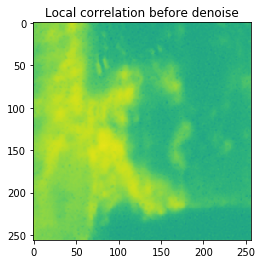

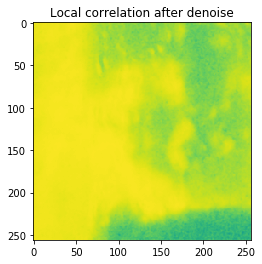

In [11]:
if check_:
    rand_block = (14, 2, 5, 0)
    mask_ = mask.blocks[rand_block]
    M = Y_d.blocks[rand_block].squeeze().compute(scheduler='threads')
    M_pca = Y_svd.blocks[rand_block].squeeze().compute(scheduler='threads')
    Cn_ = local_correlations_fft(M)
    Cn = local_correlations_fft(M_pca)

    plt.imshow(Cn_, vmin=0, vmax=1)
    plt.title('Local correlation before denoise')
    plt.show()
    plt.imshow(Cn, vmin=0, vmax=1)
    plt.title('Local correlation after denoise')
    plt.show()

#### Compare location correlation at a larger region

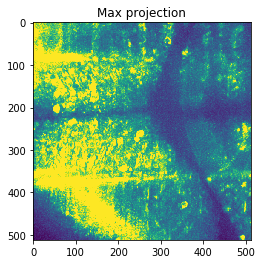

Number of processes to parallel: 32
Number of processes to parallel: 32


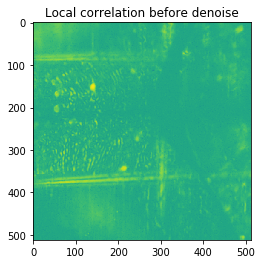

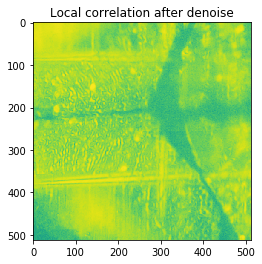

In [12]:
if check_:
    M = Y_d.blocks[14, 5:7, 3:5].squeeze().compute(scheduler='threads')
    M_pca = Y_svd.blocks[14, 5:7, 3:5].squeeze().compute(scheduler='threads')
    plt.imshow(M.max(axis=-1), vmax=20)
    plt.title('Max projection')
    plt.show()
    Cn_ = local_correlations_fft(M)
    Cn = local_correlations_fft(M_pca)
    plt.imshow(Cn_, vmin=0, vmax=1)
    plt.title('Local correlation before denoise')
    plt.show()
    plt.imshow(Cn, vmin=0, vmax=1)
    plt.title('Local correlation after denoise')
    plt.show()

## Demix
This will generate the follow files at `save_root` folder
* `demix_rlt` for each block

### Check denoised signal

In [8]:
redo_ = True

In [9]:
if redo_ or (not os.path.exists(f'{save_root}/demix_rlt/')):
    dt = 3
    is_skip = True
    numCores = 100 # ZW: 100 is enough in my testing case, can be larger
    demix_cells(save_root, dt, is_skip=is_skip, numCores = numCores)

Scheduler: tcp://10.36.111.12:43867
Dashboard link: http://10.36.111.12:8787/status


In [10]:
force_bkill_dask()

Job <56429475> is being terminated


### Check demix results

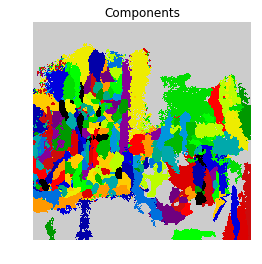

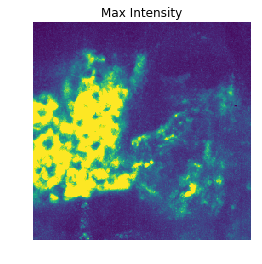

In [18]:
rand_block = (8, 1, 1, 0)
check_demix_cells(save_root, rand_block, plot_global=False, plot_mask=False)

60.0


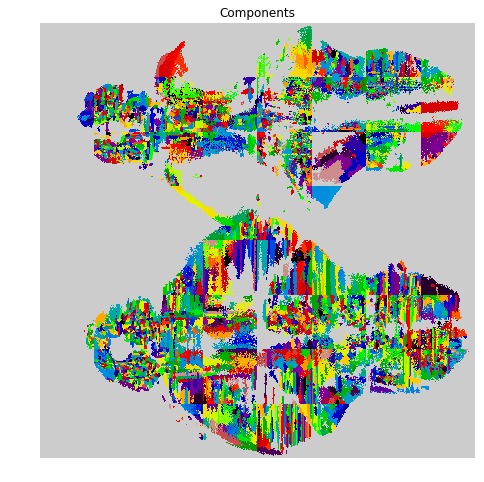

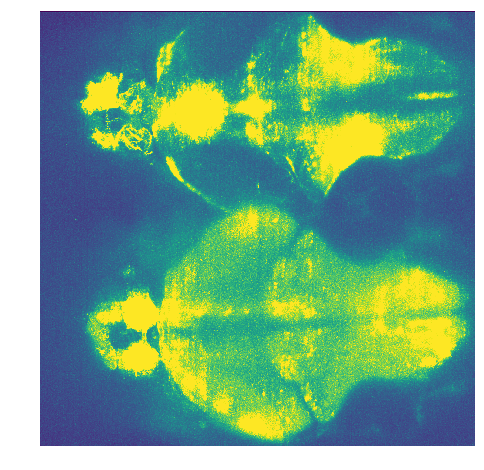

In [9]:
nlayer = 8
check_demix_cells_layer(save_root, nlayer, nsplit=8)